# Dataset classes for training
These classes extend the pytorch `torch.utils.data.Dataset` class, and output tuples of dictionaries containing `(model_input, ground_truth)` 

In [ ]:
from surfbreak import graphutils, supervision
from surfbreak import pipelines
import graphchain
import dask
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F

from surfbreak.datasets import normalize_tensor, get_wavefront_tensor_txy

Video subsample start times (seconds): [0, 120, 240, 360, 480, 600, 720, 840, 960, 1080]
Decoding /home/erik/work/surfbreak/data/shirahama_1590387334_SURF-93cm.ts  Duration: 20.1m (1204.98s)  FPS: 60.0  Emitting 1/4 of frames 
Decoding /home/erik/work/surfbreak/data/shirahama_1590387334_SURF-93cm.ts  Duration: 20.1m (1204.98s)  FPS: 60.0  Emitting 1/4 of frames 
Decoding /home/erik/work/surfbreak/data/shirahama_1590387334_SURF-93cm.ts  Duration: 20.1m (1204.98s)  FPS: 60.0  Emitting 1/4 of frames 
Decoding /home/erik/work/surfbreak/data/shirahama_1590387334_SURF-93cm.ts  Duration: 20.1m (1204.98s)  FPS: 60.0  Emitting 1/4 of frames 
Decoding /home/erik/work/surfbreak/data/shirahama_1590387334_SURF-93cm.ts  Duration: 20.1m (1204.98s)  FPS: 60.0  Emitting 1/4 of frames 
Decoding /home/erik/work/surfbreak/data/shirahama_1590387334_SURF-93cm.ts  Duration: 20.1m (1204.98s)  FPS: 60.0  Emitting 1/4 of frames 
Decoding /home/erik/work/surfbreak/data/shirahama_1590387334_SURF-93cm.ts  Duration

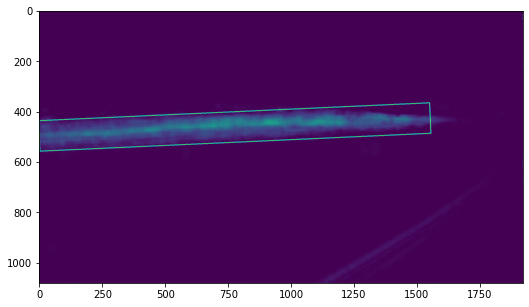

Decoding ../data/shirahama_1590387334_SURF-93cm.ts  Duration: 20.1m (1204.98s)  FPS: 60.0  Emitting 1/6 of frames 
torch.Size([100, 62, 150])
torch.Size([100, 62, 150])


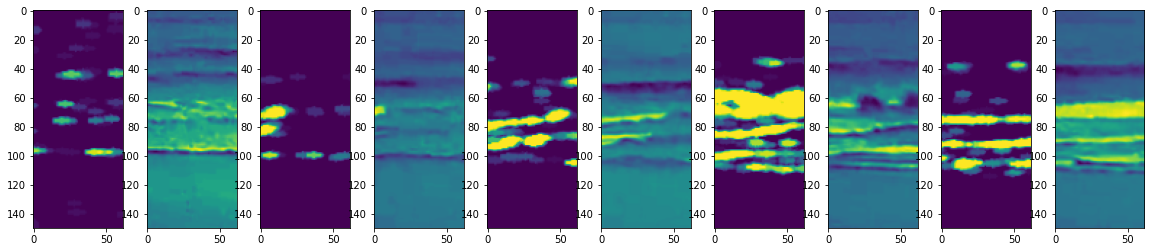

In [ ]:
param_dict = dict(video_filepath='../data/shirahama_1590387334_SURF-93cm.ts',ydim_out=150, slice_xrange=(30,90), output_dim=3, start_s=0, duration_s=20, time_axis_scale=0.5)
wf_tensor_txy = get_wavefront_tensor_txy(**param_dict, target_graph_key='result')
tdim, xdim, ydim = wf_tensor_txy.shape
print(wf_tensor_txy.shape)
assert tdim == int(param_dict['duration_s'] * 10 * param_dict['time_axis_scale']) # code assumes 10hz signal input
assert ydim == param_dict["ydim_out"]

vid_tensor_txy = get_wavefront_tensor_txy(**param_dict, target_graph_key='scaled_video_tensor')
print(vid_tensor_txy.shape)

assert wf_tensor_txy.shape == vid_tensor_txy.shape

n_plots=5
fig, axes = plt.subplots(ncols=2*n_plots, figsize=(20,4))
for i in range(n_plots):
    axes[ i*2 ].imshow(wf_tensor_txy[0+10*i].T)
    axes[i*2+1].imshow(vid_tensor_txy[0+10*i].T)

In [ ]:
from surfbreak.datasets import get_mgrid, WaveformVideoDataset

Input parameters:  {'video_filepath': '../data/shirahama_1590387334_SURF-93cm.ts', 'ydim': 120, 'xrange': (30, 91), 'timerange': (0, 73), 'time_chunk_duration_s': 30, 'time_chunk_stride_s': 15, 'time_axis_scale': 0.5}
Coordinates shape   (t,x,y,c):  torch.Size([150, 50, 120, 3])
Output tensor shape (t,x,y):  torch.Size([150, 50, 120])
Visualization of data and then coordinates values for (t, x, y):


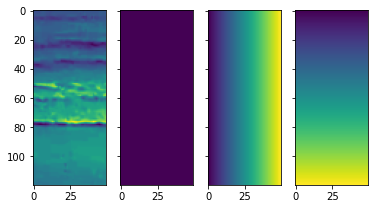

In [ ]:
param_dict = dict(video_filepath='../data/shirahama_1590387334_SURF-93cm.ts',ydim=120, xrange=(30,91), timerange=(0,73), time_chunk_duration_s=30, time_chunk_stride_s=15, 
                  time_axis_scale=0.5)
print("Input parameters: ",param_dict)
wf_dataset = WaveformVideoDataset(**param_dict)

model_input, gt = wf_dataset[0]
print("Coordinates shape   (t,x,y,c): ", model_input['coords_txyc'].shape)
assert model_input['coords_txyc'].shape[:2] == gt['wavefronts_txy'].shape[:2]
assert model_input['coords_txyc'].shape[-1] == 3

wf_tensor_txy = gt['wavefronts_txy']
print("Output tensor shape (t,x,y): ",wf_tensor_txy.shape)
assert wf_tensor_txy.shape[0] == int(param_dict['time_chunk_duration_s']*param_dict['time_axis_scale'])*10 # Correct length assuming 10hz video parsing
assert gt['timerange'][1] - gt['timerange'][0] == param_dict['time_chunk_duration_s']

vid_tensor_txy = gt['video_txy']
assert vid_tensor_txy.shape == wf_tensor_txy.shape

all_coords = model_input['coords_txyc']
all_coords_txy = all_coords.reshape(*wf_tensor_txy.shape, 3)
assert all_coords_txy.shape[:3] == wf_tensor_txy.shape

print("Visualization of data and then coordinates values for (t, x, y):")
fig, axes = plt.subplots(ncols=4, sharey=True)
axes[0].imshow(vid_tensor_txy[0].T)
for idx in range(3):
    axes[idx+1].imshow(all_coords_txy[0][:,:,idx].T)

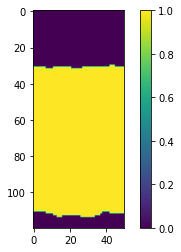

In [ ]:
plt.imshow(wf_tensor_txy.std(dim=0).T > 0.2)
plt.colorbar()

#### Confirm that time dimension handling is as expected

In [ ]:
param_dict = dict(video_filepath='../data/shirahama_1590387334_SURF-93cm.ts',ydim_out=150, slice_xrange=(10,300), output_dim=3, start_s=0, duration_s=100, time_axis_scale=0.5)
wf_tensor_txy = get_wavefront_tensor_txy(**param_dict)
assert list(wf_tensor_txy.shape) == [500, 300, 150]

In [ ]:
param_dict = dict(video_filepath='../data/shirahama_1590387334_SURF-93cm.ts',ydim_out=150, slice_xrange=(0,300), output_dim=3, start_s=0, duration_s=100, time_axis_scale=0.5)
wf_tensor_txy = get_wavefront_tensor_txy(**param_dict)
assert list(wf_tensor_txy.shape) == [500, 310, 150]

In [ ]:
param_dict = dict(video_filepath='../data/shirahama_1590387334_SURF-93cm.ts',ydim_out=100, slice_xrange=(0,300), output_dim=3, start_s=0, duration_s=50, time_axis_scale=0.5)
wf_tensor_txy = get_wavefront_tensor_txy(**param_dict)
assert list(wf_tensor_txy.shape) == [250, 206, 100]

In [ ]:
for timerange in [(0,60), (10,71), (0,99)]:
    duration = 30
    stride = 15
    param_dict = dict(video_filepath='../data/shirahama_1590387334_SURF-93cm.ts',
                      ydim=120, xrange=(30,90), timerange=timerange, time_chunk_duration_s=duration, time_chunk_stride_s=stride, 
                      time_axis_scale=0.5)

    wf_dataset = WaveformVideoDataset(**param_dict)
    for chunk_timerange in wf_dataset.video_chunk_timeranges:
        assert chunk_timerange[1] - chunk_timerange[0] == duration
    print("range: ",timerange, "  stride: ",stride,'  chunk_timeranges:', wf_dataset.video_chunk_timeranges)

range:  (0, 60)   stride:  15   chunk_timeranges: [[ 0 30]
 [15 45]
 [30 60]]
range:  (10, 71)   stride:  15   chunk_timeranges: [[10 40]
 [25 55]
 [40 70]]
range:  (0, 99)   stride:  15   chunk_timeranges: [[ 0 30]
 [15 45]
 [30 60]
 [45 75]
 [60 90]]


#### Some simple visual tests to confirm alignment between strided chunks
The middle two rows of the plots below should match (but with some differences due to chunk-based normalization)

Decoding ../data/shirahama_1590387334_SURF-93cm.ts  Duration: 20.1m (1204.98s)  FPS: 60.0  Emitting 1/6 of frames 
Decoding ../data/shirahama_1590387334_SURF-93cm.ts  Duration: 20.1m (1204.98s)  FPS: 60.0  Emitting 1/6 of frames 
torch.Size([20, 49, 120])
torch.Size([20, 49, 120])


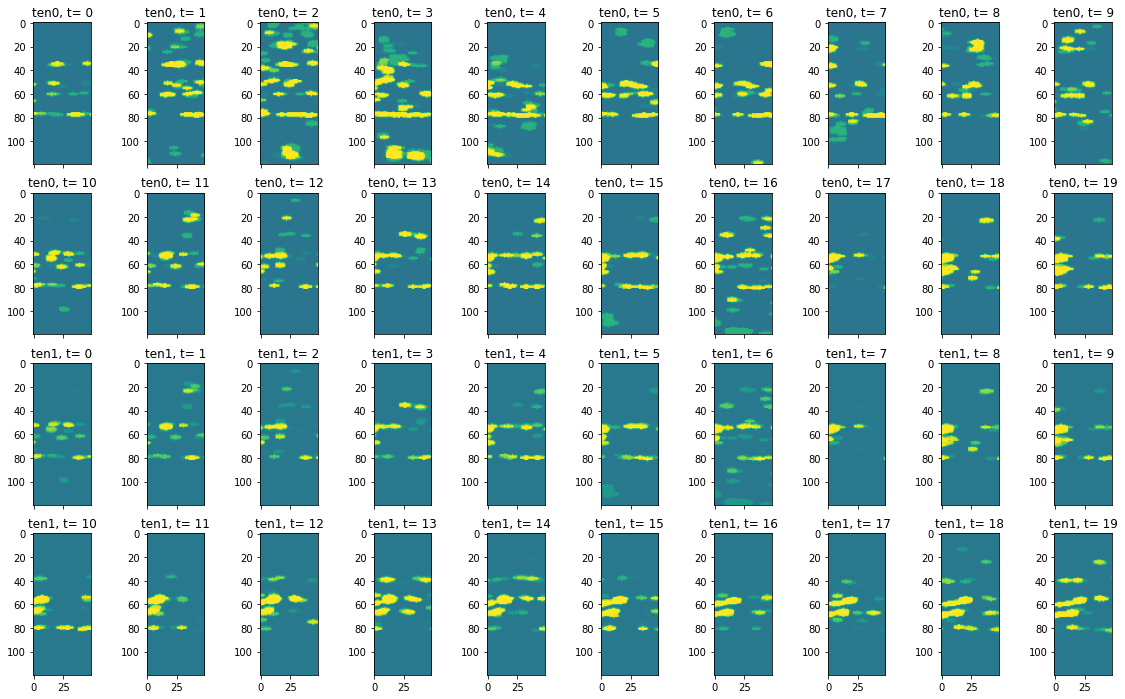

In [ ]:
param_dict = dict(video_filepath='../data/shirahama_1590387334_SURF-93cm.ts', 
                  ydim=120, xrange=(30,90), timerange=(0,60), time_chunk_duration_s=2, time_chunk_stride_s=1, time_axis_scale=1)
wf_dataset = WaveformVideoDataset(**param_dict)
in0, gt0 = wf_dataset[0]
in1, gt1 = wf_dataset[1]
tensor0 = gt0['wavefronts_txy']
tensor1 = gt1['wavefronts_txy']

# Confirm that the 10HZ assumption is still valid...
assert tensor0.shape[0] == param_dict['time_chunk_duration_s'] * 10 * param_dict['time_axis_scale']

print(tensor0.shape)
print(tensor1.shape)
n_times = tensor0.shape[0]//2
fig, axes = plt.subplots(ncols=n_times, nrows=4, figsize=(2*n_times, 12), sharex=True)
for idx in range(n_times):
    axes[0][idx].set_title("ten0, t= "+str(idx))
    axes[0][idx].imshow(tensor0[idx].T, vmin=-1, vmax=1)
    axes[1][idx].set_title("ten0, t= "+str(idx+n_times))
    axes[1][idx].imshow(tensor0[idx+n_times].T, vmin=-1, vmax=1)
    
    axes[2][idx].set_title("ten1, t= "+str(idx))
    axes[2][idx].imshow(tensor1[idx].T, vmin=-1, vmax=1)
    axes[3][idx].set_title("ten1, t= "+str(idx+n_times))
    axes[3][idx].imshow(tensor1[idx+n_times].T, vmin=-1, vmax=1)

# Develop another dataset which iterates over subsamples of a single video chunk

In [ ]:
from surfbreak.datasets import subsample_strided_buckets, WaveformChunkDataset

In [ ]:
param_dict = dict(video_filepath='../data/shirahama_1590387334_SURF-93cm.ts',
                  ydim=120, xrange=(30,91), timerange=(0,60), time_chunk_duration_s=30, time_chunk_stride_s=15, 
                  time_axis_scale=0.5)
print("Input parameters: ",param_dict)
wf_dataset = WaveformVideoDataset(**param_dict)

chunk_params = dict(xy_bucket_sidelen=10, samples_per_xy_bucket=20, time_sample_interval=5)
chunk_dataset = WaveformChunkDataset(wf_dataset, **chunk_params)

for n in range(10):
    inputs, gt = chunk_dataset[n]
    assert inputs['coords'].shape[1] == 3
    assert inputs['coords'].shape[0] == gt['wavefront_values'].shape[0]
    # bstc dimensions are (xy_batch, samples per batch, time, channel)
    bstc_coords = inputs['coords'].reshape(*gt['bst_shape'],3)
    bstc_wf_val = gt['wavefront_values'].reshape(*gt['bst_shape'], 1)
    assert bstc_coords.shape[1] == chunk_params['samples_per_xy_bucket']

    assert bstc_coords.shape[:3] == bstc_wf_val.shape[:3]
print('coords: ',inputs['coords'].shape)
print('wf_val: ', gt['wavefront_values'].shape)


print("time_sampling_offset: ", gt['time_sampling_offset'])
print('coords bstc: ', bstc_coords.shape)
print('wf_val bstc: ', bstc_wf_val.shape)


Input parameters:  {'video_filepath': '../data/shirahama_1590387334_SURF-93cm.ts', 'ydim': 120, 'xrange': (30, 91), 'timerange': (0, 60), 'time_chunk_duration_s': 30, 'time_chunk_stride_s': 15, 'time_axis_scale': 0.5}
coords:  torch.Size([36000, 3])
wf_val:  torch.Size([36000, 1])
time_sampling_offset:  4
coords bstc:  torch.Size([60, 20, 30, 3])
wf_val bstc:  torch.Size([60, 20, 30, 1])
